
# Neural Transfer
Disclaimer: This notebook is taken from [this repository](https://github.com/karfly/learning-deep-learning) with minor modifications, and is an adopted version of [this tutorial](https://pytorch.org/tutorials/advanced/neural_style_tutorial.html#sphx-glr-download-advanced-neural-style-tutorial-py) and [this repository](https://github.com/pytorch/examples). Images with loss explanations are taken from [this blogpost](https://towardsdatascience.com/perceptual-losses-for-real-time-style-transfer-and-super-resolution-637b5d93fa6d).

Introduction
------------

This tutorial explains how to implement the simplified version of [Neural-Style algorithm](https://arxiv.org/abs/1508.06576) developed by Leon A. Gatys, Alexander S. Ecker and Matthias Bethge.
Neural-Style, or Neural-Transfer, allows you to take an image and reproduce it with a new artistic style. The algorithm takes three images, an **input image**, a **content-image**, and a **style-image**, and changes the input  to resemble the content of the content-image and the artistic style of the style-image.

Underlying Principle
--------------------

The principle is simple: we define two distances, one for the content ($D_C$) and one for the style ($D_S$). $D_C$ measures how different the content is between two images while $D_S$ measures how different the style is between two images. Then, we take a third image, the input, and transform it to minimize both its content-distance with the content-image and its style-distance with the style-image. Now we can import the necessary packages and begin the neural transfer.

Importing Packages and Selecting a Device
-----------------------------------------
Below is a  list of the packages needed to implement the neural transfer.

-  ``torch``, ``torch.nn``, ``numpy`` (indispensables packages for
   neural networks with PyTorch)
-  ``torch.optim`` (efficient gradient descents)
-  ``PIL``, ``PIL.Image``, ``matplotlib.pyplot`` (load and display
   images)
-  ``torchvision.transforms`` (transform PIL images into tensors)
-  ``torchvision.models`` (train or load pre-trained models)

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

%matplotlib inline
import matplotlib
from matplotlib import pylab as plt
plt.rcParams['figure.figsize'] = (15, 15)

import torchvision.transforms as transforms
import torchvision.models as models

import copy

!gdown --id 1NRUThc2mraGvzLrbendMS4S7alNF9WZP
!tar -xzf materials.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1NRUThc2mraGvzLrbendMS4S7alNF9WZP
To: /content/materials.tar.gz
100% 298k/298k [00:00<00:00, 104MB/s]


Next, we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU. We can use ``torch.cuda.is_available()`` to detect if there is a GPU available. Next, we set the ``torch.device`` for use throughout the tutorial. Also the ``.to(device)`` method is used to move tensors or modules to a desired device. 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Then we define paths to our content- and style-images (there are som examples in `./data`):

In [ ]:
style_image_path = "./data/starry-night.jpg"
content_image_path = "./data/amsterdam.jpg"

Loading the Images
------------------

Now we will import the style and content images. The original PIL images have values between 0 and 255, but when transformed into torch tensors, their values are converted to be between 0 and 1. The images also need to be resized to have the same dimensions. An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1. If you try to feed the networks with 0 to 255 tensor images, then the activated feature maps will be unable sense the intended content and style. However, pre-trained networks from the Caffe library are trained with 0 to 255 tensor images. 

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

image_transform_fn = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()  # transform it into a torch tensor
])


def image_loader(image_name):
    image = Image.open(image_name)
    
    # fake batch dimension required to fit network's input dimensions
    image = image_transform_fn(image).unsqueeze(0)
    return image.to(device, torch.float)


style_image = image_loader(style_image_path)
content_image = image_loader(content_image_path)

assert style_image.size() == content_image.size(), \
    "we need to import style and content images of the same size"

Now, let's create a function that displays an image by reconverting a 
copy of it to PIL format and displaying the copy using 
``plt.imshow``. We will try displaying the content and style images 
to ensure they were imported correctly.



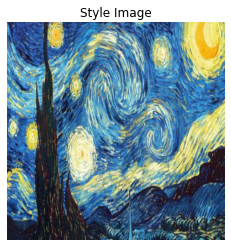

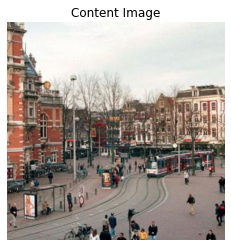

In [ ]:
def imshow(tensor, title=None):
    image = tensor.detach().cpu().numpy()
    image = image.squeeze(0)  # remove the fake batch dimension
    image = image.transpose(1, 2, 0)  # making channel dim last
    
    plt.imshow(image)
    plt.axis('off')
    if title is not None:
        plt.title(title)


imshow(style_image, title='Style Image')
plt.show()

imshow(content_image, title='Content Image')
plt.show()

## Task 1. Extracting VGG-16 features

Now we need to import a pre-trained neural network. We will use a VGG-16 network similar to the one used in the paper.

PyTorch’s implementation of VGG is a module divided into two child ``Sequential`` modules: ``features`` (containing convolution and pooling layers), and ``classifier`` (containing fully connected layers). We will use the ``features`` module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using ``.eval()``.

Here we need to hack pretrained VGG-16 model to extract features from intermediate layers `relu1_2`, `relu2_2`, `relu3_3`, `relu4_3` (ReLUs just before MaxPool2d layers, except the last one). Below you need to hack VGG16 and return intermediate features in `.forward()`:

In [ ]:
class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        
        vgg_pretrained_features = models.vgg16(pretrained=True).features
        
        # iterate through the sequential layer 
        # and save the 0-3, 4-8, 9-15, 16-22 slices of the VGG16 layers
        # into separate nn.Sequential-s 
        # your code here:
        layers = []
        for i in range(0, 4):
            layers.append(vgg_pretrained_features[i])
        self.slice_1 = nn.Sequential(*layers)

        layers = []
        for i in range(4, 9):
            layers.append(vgg_pretrained_features[i])
        self.slice_2 = nn.Sequential(*layers)

        layers = []
        for i in range(9, 16):
            layers.append(vgg_pretrained_features[i])
        self.slice_3 = nn.Sequential(*layers)

        layers = []
        for i in range(16, 23):
            layers.append(vgg_pretrained_features[i])
        self.slice_4 = nn.Sequential(*layers)

        
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        ## your code here: just forward slice by slice and save intermediate features
        out_1 = self.slice_1(x)
        out_2 = self.slice_2(out_1)
        out_3 = self.slice_3(out_2)
        out_4 = self.slice_4(out_3)

        out = [out_1, out_2, out_3, out_4]
        
        return out

## Normalization
Additionally, VGG networks are trained on images with each channel normalized by **mean=[0.485, 0.456, 0.406]** and **std=[0.229, 0.224, 0.225]**. We will use them to normalize the image before sending it into the network:

In [ ]:
normalization_mean = [0.485, 0.456, 0.406]
normalization_std = [0.229, 0.224, 0.225]

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, x):
        mean = self.mean.clone().to(x.device)
        std = self.std.clone().to(x.device)
        
        result = (x - mean) / std
        return result

## Task 2. Perceptual loss functions

### Content loss

Below is the formula with explanation of a content loss.

<img src="https://i.imgur.com/ysTyVEp.jpg" width=1000 align="center"/>

In [ ]:
class ContentLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_features, target_features):
        """Calculates content loss of 2 given feature maps

        Args:
            pred_features (torch tensor of shape (b, c, h, w)): features of input image
            target_features (torch tensor of shape (b, c, h, w)): features of content image
        """
        ## your code here
        return F.mse_loss(pred_features, target_features)

## Style loss

Same scheme for style loss:

<img src="https://i.imgur.com/kfu78E7.jpg" width=1000 align="center"/>

Here, $G$ denotes a Gram Matrix. $G = \frac{1}{N} FF^T,\ F \in \mathbb{R}^{C \times N},\ G \in \mathbb{R}^{C \times C},\ F$ denotes a feature map.

**Note 1**: to calculate **gram matrix** of a feature map with the shape $(c, h, w)$, you need to squeeze spatial dimensions into a vector, obtaining a tensor of shape $(c, h \times w)$, and after that calculate the gram matrix.

**Note 2**: don't forget to norm the resulting loss by $c \times c$

In [ ]:
class StyleLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, pred_features, target_features):
        """Calculates content loss of 2 given feature maps

        Args:
            pred_features (torch tensor of shape (b, c, h, w)): features of input image
            target_features (torch tensor of shape (b, c, h, w)): features of content image
        """
        
        pred_gram_matrix = self.gram_matrix(pred_features)
        target_gram_matrix = self.gram_matrix(target_features)

        loss = F.mse_loss(pred_gram_matrix, target_gram_matrix) ## your code here: implement the loss described above
        
        return loss
    
    def gram_matrix(self, features):
        """Calculates gram matrix of given feature map

        Args:
            features (torch tensor of shape (b, c, h, w)): feature map
            
        Returns:
            gram_matrix (torch tensor of shape (b, c, c)): resulting gram matrix
        """
        
        ## your code here: calculate the gram matrix
        b, c, h, w = features.shape
        features = features.view(b, c, h*w)
        gram_matrix = torch.bmm(features, features.transpose(1, 2)) / (h*w)
        
        return gram_matrix

## Task 3. Let's do neural style transfer

Setup model:

In [ ]:
vgg16 = Vgg16().to(device)
vgg16.eval()

Vgg16(
  (slice_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (slice_2): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
  )
  (slice_3): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): ReLU(inplace=True)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
  )
  (slice_

Setup normalizer:

In [ ]:
normalizer = Normalization(normalization_mean, normalization_std).to(device)

Setup perceptual losses:

In [ ]:
content_criterion = ContentLoss().to(device)
style_criterion = StyleLoss().to(device)

Setup layers for content and style losses. Your can play with these parameteres:

In [ ]:
content_loss_layers = ['relu2_2']
style_loss_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3']

Next, we select the input image. You can use a copy of the content image or white noise.

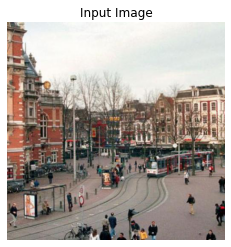

In [ ]:
input_image = content_image.clone()
input_image.requires_grad_()

# if you want to use white noise instead uncomment the below line:
# input_image = torch.randn_like(content_image)

imshow(input_image, title='Input Image')

Epoch:  0


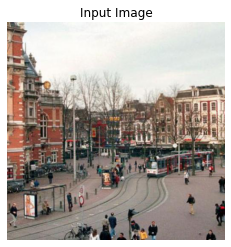

Epoch:  10


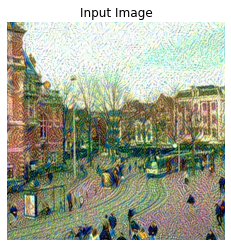

Epoch:  20


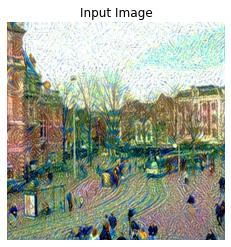

Epoch:  30


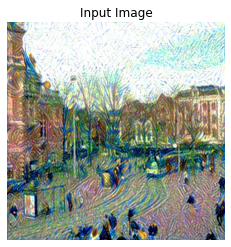

Epoch:  40


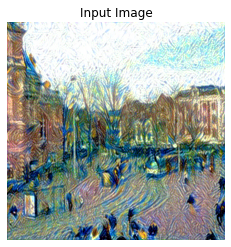

Epoch:  50


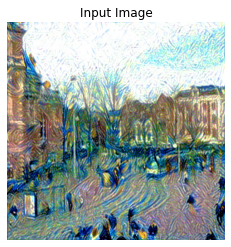

Epoch:  60


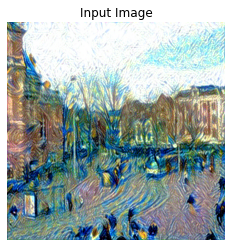

Epoch:  70


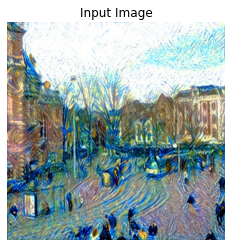

Epoch:  80


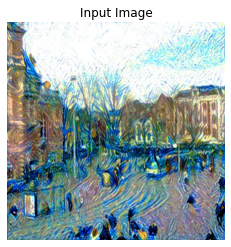

Epoch:  90


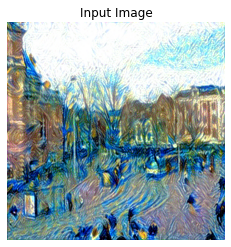

Epoch:  100


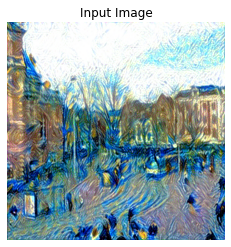

Epoch:  110


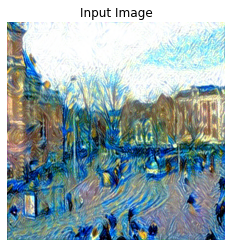

Epoch:  120


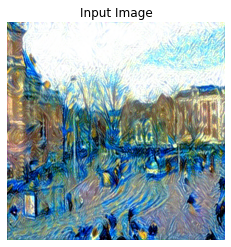

Epoch:  130


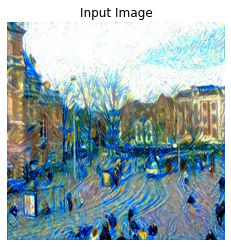

Epoch:  140


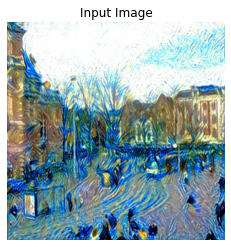

Epoch:  150


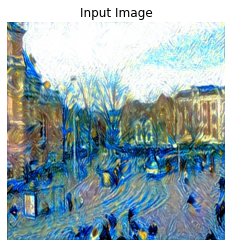

Epoch:  160


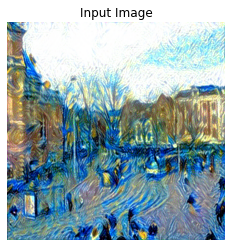

Epoch:  170


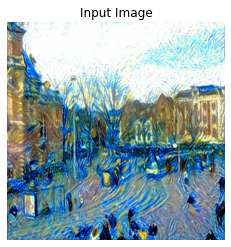

Epoch:  180


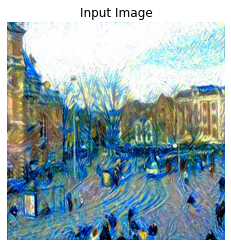

Epoch:  190


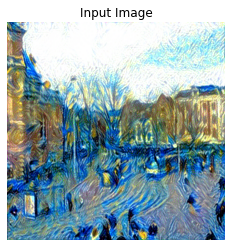

In [ ]:
n_epochs = 200

# it's very important to tune loss weights
content_weight = 1
style_weight = 2e3

content_image_features = vgg16(normalizer(content_image)) ## your code here (don't forget to normalize!)
style_image_features = vgg16(normalizer(style_image)) ## your code here (don't forget to normalize!)

opt = torch.optim.Adam([input_image], lr=0.1)  ## your code here: tune lr

for epoch in range(n_epochs):
    if epoch % 10 == 0:
        print("Epoch: ", epoch)
        imshow(torch.clamp(input_image.clone(), 0.0, 1.0), title='Input Image')
        plt.show()
        
    x = torch.clamp(input_image, 0.0, 1.0)  # clamp image to be in [0.0, 1.0] range
    input_image_features = vgg16(normalizer(x))
    
    # content loss
    content_loss = 0.0
    for i in [3]:
        content_loss += content_criterion(input_image_features[i], content_image_features[i])
    
    # style loss
    style_loss = 0.0
    ## your code here: calculate the style loss
    for i in [0, 1, 2, 3]:
        style_loss += style_criterion(input_image_features[i], style_image_features[i])
    style_loss /= 4

    # total loss (weighted sum of content and style losses)
    total_loss = content_loss * content_weight + style_loss * style_weight
    
    # optimize
    opt.zero_grad()
    total_loss.backward()
    opt.step()

Final result:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


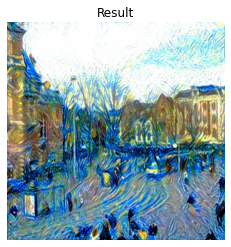

In [ ]:
imshow(input_image, title='Result')